In [37]:
import os
from glob import glob
import csv 
import graspy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
#uncomment when placed into model folder not doc
#from .base import BaseGraphEstimator, _calculate_p

from scipy.stats import bernoulli 
import pandas as pd 

from graspy.simulations import sbm, er_np, er_nm
from graspy.plot import heatmap

from graspy.models.base import BaseGraphEstimator 
from graspy.utils.utils import (
    augment_diagonal,
    cartprod,
    import_graph,
    is_unweighted,
    remove_loops,
    symmetrize,
)
import matplotlib.pyplot as plt

from PyNonpar.twosample import wilcoxon_mann_whitney_test
import seaborn as sns
from seaborn import *
from dfply import *

%matplotlib inline

## SIEM Functions/Classes

In [197]:
class SIEMEstimator(BaseGraphEstimator):
    r"""
    Stochastic Block Model 
    The stochastic block model (SBM) represents each node as belonging to a block 
    (or community). For a given potential edge between node :math:`i` and :math:`j`, 
    the probability of an edge existing is specified by the block that nodes :math:`i`
    and :math:`j` belong to:
    :math:`P_{ij} = B_{\tau_i \tau_j}`
    where :math:`B \in \mathbb{[0, 1]}^{K x K}` and :math:`\tau` is an `n\_nodes` 
    length vector specifying which block each node belongs to. 
    Read more in the :ref:`tutorials <models_tutorials>`
    Parameters
    ----------
    directed : boolean, optional (default=True)
        Whether to treat the input graph as directed. Even if a directed graph is inupt, 
        this determines whether to force symmetry upon the block probability matrix fit
        for the SBM. It will also determine whether graphs sampled from the model are 
        directed. 
    loops : boolean, optional (default=False)
        Whether to allow entries on the diagonal of the adjacency matrix, i.e. loops in 
        the graph where a node connects to itself. 
    n_components : int, optional (default=None)
        Desired dimensionality of embedding for clustering to find communities.
        ``n_components`` must be ``< min(X.shape)``. If None, then optimal dimensions 
        will be chosen by :func:`~graspy.embed.select_dimension``.
    min_comm : int, optional (default=1)
        The minimum number of communities (blocks) to consider. 
    max_comm : int, optional (default=10)
        The maximum number of communities (blocks) to consider (inclusive).
    cluster_kws : dict, optional (default={})
        Additional kwargs passed down to :class:`~graspy.cluster.GaussianCluster`
    embed_kws : dict, optional (default={})
        Additional kwargs passed down to :class:`~graspy.embed.AdjacencySpectralEmbed`
    Attributes
    ----------
    block_p_ : np.ndarray, shape (n_blocks, n_blocks)
        The block probability matrix :math:`B`, where the element :math:`B_{i, j}`
        represents the probability of an edge between block :math:`i` and block 
        :math:`j`.
    p_mat_ : np.ndarray, shape (n_verts, n_verts)
        Probability matrix :math:`P` for the fit model, from which graphs could be
        sampled.
    vertex_assignments_ : np.ndarray, shape (n_verts)
        A vector of integer labels corresponding to the predicted block that each node 
        belongs to if ``y`` was not passed during the call to ``fit``. 
    block_weights_ : np.ndarray, shape (n_blocks)
        Contains the proportion of nodes that belong to each block in the fit model.
    See also
    --------
    graspy.simulations.siem
    References
    ----------
    .. [1]  Holland, P. W., Laskey, K. B., & Leinhardt, S. (1983). Stochastic
            blockmodels: First steps. Social networks, 5(2), 109-137.
    """
    def __init__(
        self,
        directed=True,
        loops=False,
#         n_components=None,
#         min_comm=1,
#         max_comm=10,
#         cluster_kws={},
#         embed_kws={},
    ):
        super().__init__(directed=directed, loops=loops)
        self.model = {}
#         _check_common_inputs(n_components, min_comm, max_comm, cluster_kws, embed_kws)
#         self.cluster_kws = cluster_kws
#         self.n_components = n_components
#         self.min_comm = min_comm
#         self.max_comm = max_comm
#         self.embed_kws = embed_kws
#     def _estimate_assignments(self, graph):
#         """
#         Do some kind of clustering algorithm to estimate communities
#         There are many ways to do this, here is one
#         """
#         embed_graph = augment_diagonal(graph)
#         latent = AdjacencySpectralEmbed(
#             n_components=self.n_components, **self.embed_kws
#         ).fit_transform(embed_graph)
#         if isinstance(latent, tuple):
#             latent = np.concatenate(latent, axis=1)
#         gc = GaussianCluster(
#             min_components=self.min_comm,
#             max_components=self.max_comm,
#             **self.cluster_kws
#         )
#         vertex_assignments = gc.fit_predict(latent)
#         self.vertex_assignments_ = vertex_assignments
    def fit(self, graph, edge_comm, weighted):
        """
        Fit the SIEM to a graph
        Parameters
        ----------
        graph : array_like or networkx.Graph [nxn]
            Input graph to fit
        edge_comm : 2d list of k tuples (k_communities)
            Categorical labels for the block assignments of the graph
        weighted: boolean or float
            Boolean: True - do nothing or False - ensure everything is 0 or 1
            Float: binarize and use float as cutoff
        """
        
        if isinstance(graph, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph)):
            graph = nx.convert_matrix.to_numpy_array(graph)
        #checks
        n = graph.shape[0]

        if not(isinstance(graph, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph, np.ndarray))):
            msg = "graph must be a np.array or networkx.Graph"
            raise TypeError(msg)
        if not isinstance(edge_comm, list):
            msg = "Edge_comm must be a list"
            raise TypeError(msg)
        if len(edge_comm) >= n:
            msg = "warning more communities than n vertices"
            print(msg)
        if len(edge_comm) > n**2:
            msg = "Too many communities for this graph"
            raise TypeError(msg)
        if not(type(weighted) == bool or type(weighted) == float): 
            msg = "weighted must be a boolean or float"
            raise TypeError(msg)
        
        graph = import_graph(graph)
        if isinstance(weighted,float): 
            graph = 1*(graph>weighted)
        
        if weighted == False: 
            if not np.array_equal(graph, graph.astype(bool)):
                msg = "graph of weighted = False must have binary inputs"
                raise TypeError(msg)
        #fit model and store edge_comms  
        self.edge_comm = edge_comm
        
        for i in range(0,len(edge_comm)):
            comms = []
            for x in edge_comm[i]:
                comms.append(graph[x])
                
            self.model[i] = np.array(comms)
        return
    
    def test(self, method="wilcox", alternative="greater", alpha=.05):
        """
        Test whether there exists a difference in the edge weights from one
        community to another. This method should be called after fitting.
        Parameters
        ----------
        method: str, optional (default="hodge")
            The approach to use for testing. Options are:
                "hodge": The Hodge-Lehmann Estimator. Number of unique communities 
                in `self.edge_comm` should be 2. The parameter `alternative` will specify the 
                alternative hypothesis, where the edge communities will be considered in the order
                given by `self.edge_comm.keys()`.
        alternative: str, optional (default="greater")
            The alternative hypothesis for the test. This option is supported only
            in the event that the number of edge communities is 2. A warning will be passed
            if the number of communities exceeds 2, and an alternative hypothesis is specified.
            The possible options for an alternative hypothesis are "greater" (one-sided),
            "less" (one-sided), and "neq" (two-tailed).
            In the case that more than two communities are present, 
            `alternative` should be specified as `None`.
        alpha: float (default=.05)
            The significance 
        """
        if not self.model:
            raise ValueError("You have not fit a model yet.")
        if (method == "wilcox" and len(self.edge_comm) != 2):
            msg = """wilcox rank-sum test can only be applied when the number
            of unique edge-communities is 2. Your data has {}.""".format(len(self.edge_comm))
            raise ValueError(msg)
        if not (method in ["wilcox"]):
            raise ValueError("You have not passed a supported method.")
        if (method == "wilcox" and alternative not in ["greater", "less", "neq"]):
            msg = "You have not specified a valid alternative. Taking to be neq (two-tailed)..."
            warnings.warn(msg)
            alternative = "neq"
        if method not in ["wilcox"] and not (alternative is None):
            msg = """You have provided an alternative hypothesis, but the method
            you have selected does not support an alternative hypothesis. Taking to be None..."""
            warnings.warn(msg)
            alternative = None
        if method is "wilcox":
            keys = self.model.keys()
            test = wilcoxon_mann_whitney_test(self.model[keys[0]], self.model[keys[1]],
                                              alternative=alternative, alpha=alpha)
        return test
        
    
def siem(n, p,edge_comm, directed=False, loops=False, wt=None, wtargs=None):
    """
    Samples a graph from the structured independent edge model (SIEM) 
    SIEM produces a graph with specified communities, in which each community can
    have different sizes and edge probabilities. 
    Read more in the :ref:`tutorials <simulations_tutorials>`
    Parameters
    ----------
    n: int
        Number of vertices
    p: list of int of length K (k_communities)
        Probability of an edge existing within the corresponding communities, where p[i] indicates 
        the probability of an edge existing in the edge_comm[i]
    edge_comm: 2d list of K tuples (k_communities)
        tuple is the indices for the edge within the kth community.
    directed: boolean, optional (default=False)
        If False, output adjacency matrix will be symmetric. Otherwise, output adjacency
        matrix will be asymmetric.
    loops: boolean, optional (default=False)
        If False, no edges will be sampled in the diagonal. Otherwise, edges
        are sampled in the diagonal.
    wt: object or list of K objects (k_communities)
        if Wt is an object, a weight function to use globally over
        the siem for assigning weights. If Wt is a list, a weight function for each of
        the edge communities to use for connection strengths Wt[i] corresponds to the weight function
        for edge community i. Default of None results in a binary graph
    wtargs: dictionary or array-like, shape (k_communities)
        if Wt is an object, Wtargs corresponds to the trailing arguments
        to pass to the weight function. If Wt is an array-like, Wtargs[i, j] 
        corresponds to trailing arguments to pass to Wt[i, j].
    return_labels: boolean, optional (default = False)
        IF True, returns the edge-communities as well
    References
    ----------
    Returns
    -------
    A: ndarray, shape (sum(n), sum(n))
        Sampled adjacency matrix
    T: returns the edge-communities if return_labels == True
    Examples
    --------
    >>> np.random.seed(1)
    >>> n = [3, 3]
    >>> p = [[0.5, 0.1], [0.1, 0.5]]
    To sample a binary 2-block SBM graph:
    >>> sbm(n, p)
    array([[0., 0., 1., 0., 0., 0.],
           [0., 0., 1., 0., 0., 1.],
           [1., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0., 0.],
           [0., 1., 0., 0., 0., 0.]])
    To sample a weighted 2-block SBM graph with Poisson(2) distribution:
    >>> wt = np.random.poisson
    >>> wtargs = dict(lam=2)
    >>> sbm(n, p, wt=wt, wtargs=wtargs)
    array([[0., 4., 0., 1., 0., 0.],
           [4., 0., 0., 0., 0., 2.],
           [0., 0., 0., 0., 0., 0.],
           [1., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 2., 0., 0., 0., 0.]])
    """
    # Check n
    if not isinstance(n, (int)):
        msg = "n must be a int, not {}.".format(type(n))
        raise TypeError(msg)
    # Check edge_comm 
    if not isinstance(edge_comm, (list)):
        msg = "edge_comm must be a 2d list of length k."
        raise TypeError(msg)
    else: 
        for i in range(len(edge_comm)):
            for x in edge_comm[i]:
                if not (len(x)==2 and isinstance (x,tuple)):
                    msg = "The edge_comm list must contain tuples of 2 elements."
                    raise TypeError(msg)
        #edge_comm = np.array(edge_comm)
        #generate temporary adjacency matrix to check upper triangular?
        if (directed == True) and (loops == True):
            if not(sum(len(x) for x in edge_comm) <= n**2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2 !".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)
        elif (directed == True) and (loops == False): 
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)/2): 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == True):
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == False): 
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n**2/2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
    # Check p
    if not isinstance(p, (list, np.ndarray)):
        msg = "p must be a list or np.array, not {}.".format(type(p))
        raise TypeError(msg)
    else:
        p = np.array(p)
        if not np.issubdtype(p.dtype, np.number):
            msg = "There are non-numeric elements in p"
            raise ValueError(msg)
        elif np.any(p < 0) or np.any(p > 1):
            msg = "Values in p must be in between 0 and 1."
            raise ValueError(msg)
        elif len(p) != len(edge_comm):
            msg = "# of Probabilities and # of Communities Don't Match Up"
            raise ValueError(msg)
    # Check wt and wtargs
    if (wt is not None) and (wtargs is not None): 
        if callable(wt):
            #extend the function to size of k 
            wt = np.full(len(edge_comm), wt, dtype=object)
            wtargs = np.full(len(edge_comm), wtargs, dtype=object)
        elif type(wt) == list:
            if all(callable(x) for x in wt): 
                # if not object, check dimensions
                if len(wt) != (len(edge_comm)):
                    msg = "wt must have size k, not {}".format(len(wt))
                    raise ValueError(msg)
                if len(wtargs) != (len(edge_comm)):
                    msg = "wtargs must have size k , not {}".format(len(wtargs))
                    raise ValueError(msg)
                # check if each element is a function
                for element in wt.ravel():
                    if not callable(element):
                        msg = "{} is not a callable function.".format(element)
                        raise TypeError(msg)   
            else: 
                msg = "list must contain all callable objects"
                raise ValueError(msg)
        else:
            msg = "wt must be a callable object or list of callable objects"
            raise ValueError(msg)

    K = len(edge_comm) # the number of communities
    # End Checks, begin simulation
    A = np.zeros((n,n))

    # list of lists of 2-d tuples version
    for i in range(0, K):
        #sample bernoulli at once
        rvs = bernoulli.rvs(p[i],size = len(edge_comm[i]))
        #iterate over each index
        for x in range(len(edge_comm[i])):
            #set each equal to bernoulli 
            A[edge_comm[i][x]] = rvs[x]
            #adjust adjacency matrix with any weight args. 
            if (wt is not None) and (wtargs is not None): 
                    A[edge_comm[i][x]] = A[edge_comm[i][x]]*wt[i](**wtargs[i])
    
    if not directed:
        A = A + A.T - np.diag(A)
        
    return A


## Data Analysis and Loading Functions

In [186]:
def gen_ips_con_edge_comm(split_pt):
    """
    generate edge_comm for
    """
    ips = []
    con = []

    for i in range(0,70):
        for j in range(0,70):
            if (i <= split_pt) & (j  <= split_pt):
                ips.append((i,j))
            elif (i> split_pt) & (j>split_pt):
                ips.append((i,j))
            else: 
                con.append((i,j))

    return [ips,con]

def gen_homo_heter_edge_comm(split_pts):
    homo = []
    heter = []

    for i in range(0,70):
        for j in range(0,70):
            if i in split_pts[0:32]:
                if j == split_pts[i+32]:
                    homo.append((i,j))
                else:
                    heter.append((i,j))
            elif (i in split_pts[32]) or (i in split_pts[67]):
                if (j in split_pts) or (j in split_pts[67]):
                    homo.append((i,j))
                else:
                    heter.append((i,j))
            elif i in split_pts[33:68]:
                if j == split_pts[i-34]:
                    homo.append((i,j))
                else: 
                    heter.append((i,j))
    return [homo,heter]
    
    
def mag_ips_con(path,split_pt):
    """
    path: str, the CSV file path.
    split_pt: int, the node number which separates the left hemisphere and right hemisphere.
    The function is aim to calculate the average edge-weighted difference between ipsilateral and contralateral.
    """
    # Read in CSV file
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    result =[]
    for item in reader:
        result.append(item[0].split(" "))
    csvFile.close()
    
    # Separate the three columns
    column1 = []
    column2 = []
    column3 = []
    for i in range(len(result)):
        column1.append(int(result[i][0]))
        column2.append(int(result[i][1]))
        column3.append(float(result[i][2]))

    # Categorize the ips and con part
    ips = []
    con = []
    for i in range(len(result)):
        if (column1[i]<= split_pt) & (column2[i]<=split_pt):
            ips.append(column3[i])
        elif (column1[i]> split_pt ) & (column2[i]>split_pt):
            ips.append(column3[i])
        else:
            con.append(column3[i])

    return np.mean(ips)-np.mean(con)

def mag_homo_heter(path,split_pt):
    """
    path: str. The CSV file path.
    split_pt: list. The list indicates the nodes number included in every desikan region. The first 34 
    are in left hemisphere and the last 34 are in right hemisphere. The 1st should be symmetric to the 35th, etc. 
    The 34th and the 68th should be the list who has two nodes.
    The function is aim to calculate the average edge-weighted difference between homotopic and heterotopic.
    """
    # Read in CSV file
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    result =[]
    for item in reader:
        result.append(item[0].split(" "))
    csvFile.close()
    
    # Separate the three columns
    column1 = []
    column2 = []
    column3 = []
    for i in range(len(result)):
        column1.append(int(result[i][0]))
        column2.append(int(result[i][1]))
        column3.append(float(result[i][2]))
    
    # Categorize the homo and heter part
    homo = []
    heter = []
    for i in range(len(result)):
        if column1[i] in split_pt[0:32]:
            if column2[i] == split_pt[column1[i]+32]:
                homo.append(column3[i])
            else:
                heter.append(column3[i])
        elif (column1[i] in split_pt[32]) or (column1[i] in split_pt[67]):
            if (column2[i] in split_pt[32]) or (column2[i] in split_pt[67]):
                homo.append(column3[i])
            else:
                heter.append(column3[i])
        elif column1[i] in split_pt[33:68]:
            if column2[i] == split_pt[column1[i]-34]:
                homo.append(column3[i])
            else:
                heter.append(column3[i])
                       
#     print(len(homo))
#     print(len(heter))
    return np.mean(homo)-np.mean(heter)

def dataset_analysis_ips_con(PATH,split_pt):
    """
    PATH: path to dataset main directory
    split_pt: points to split dataset by (dependent on the atlas)
    
    """
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    avg_edge_weight_diff = []
    for path in all_csv_files: 
        avg_edge_weight_diff.append(mag_ips_con(path,split_pt))
    avg_edge_weight_diff /= np.linalg.norm(avg_edge_weight_diff)
    return avg_edge_weight_diff

def dataset_analysis_homo_heter(PATH,split_pts):
    """
    PATH: path to dataset main directory
    split_pts: list of points to split dataset by (dependent on the atlas)
    
    """
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    avg_edge_weight_diff = []
    for path in all_csv_files: 
        avg_edge_weight_diff.append(mag_homo_heter(path,split_pts))
    avg_edge_weight_diff /= np.linalg.norm(avg_edge_weight_diff)
    return avg_edge_weight_diff

def datasets_generate_ips_con_plot(dMRI_PATHS,fMRI_PATHS,split_pt):
    """
    dMRI_PATHS: list of paths to dMRI datasets
    fMRI_PATHS: list of paths to fMRI datasets
    Generates KDE estimate for a series of datasets. 
    """
    plt.figure
    for path in dMRI_PATHS:
        print(path)
        weight_diffs = dataset_analysis_ips_con(path,split_pt)
        print(weight_diffs)
#         ax = sns.distplot(np.absolute(weight_diffs), color = 'Orange', hist = False, norm_hist = True)
        ax = sns.kdeplot(np.absolute(weight_diffs),color = 'Orange')
        ax.set_title('Magnitude Within-Modality')
        ax.set(xlabel = 'Ipsi - Contra', ylabel = 'Count/KDE')
    for path in fMRI_PATHS:
        print(path)
        weight_diffs = dataset_analysis_ips_con(path,split_pt)
        print(weight_diffs)
#         ax = sns.distplot(np.absolute(weight_diffs), color = 'Blue', hist = False, norm_hist = True)
        ax = sns.kdeplot(np.absolute(weight_diffs),color = 'Blue')
        ax.set_title('Magnitude Within-Modality')
        ax.set(xlabel = 'Ipsi - Contra', ylabel = 'Count/KDE')

def datasets_generate_homo_heter_plot(dMRI_PATHS,fMRI_PATHS,split_pts):
    """
    dMRI_PATHS: list of paths to dMRI datasets
    fMRI_PATHS: list of paths to fMRI datasets
    split_pts: list of point mappings for nodes to regions by list index. (34 regions in total)
    Generates KDE estimate for a series of datasets. 
    """
    plt.figure
    for path in dMRI_PATHS:
        print(path)
        weight_diffs = dataset_analysis_homo_heter(path,split_pts)
        print(weight_diffs)
        ax = sns.distplot(np.absolute(weight_diffs), color = 'Orange', hist = False, norm_hist = True)
        ax.set_title('Magnitude Within-Modality')
        ax.set(xlabel = 'Homo - Hetero', ylabel = 'Count/KDE')
    for path in fMRI_PATHS:
        print(path)
        weight_diffs = dataset_analysis_homo_heter(path,split_pts)
        print(weight_diffs)
        ax = sns.distplot(np.absolute(weight_diffs), color = 'Blue', hist = False, norm_hist = True)
        ax.set_title('Magnitude Within-Modality')
        ax.set(xlabel = 'Homo - Hetero', ylabel = 'Count/KDE')
    
    
    
    

In [187]:
dMRI_datasets = []
fMRI_datasets = []
datasets_path = '/Users/wilsontang/Desktop/m2g_csvs'

dMRI_dataset_names = ['/BNU1_DMRI','/HNU1']#,'/SWU1']
fMRI_dataset_names = ['/BNU1_FMRI','/SWU1_FMRI', '/SWU2_FMRI']

for dataset in dMRI_dataset_names:
    dMRI_datasets.append(datasets_path + dataset)
for dataset in fMRI_dataset_names:
    fMRI_datasets.append(datasets_path + dataset)

print(datasets)

desikan_split_pt = 35 

#split for desikan
desikan_split_pts = [i for i in range(1,70)]
desikan_split_pts.remove(34)
desikan_split_pts[32]=[33,34]
desikan_split_pts[67]=[69,70]



['/Users/wilsontang/Desktop/m2g_csvs/BNU1_DMRI', '/Users/wilsontang/Desktop/m2g_csvs/BNU1_FMRI', '/Users/wilsontang/Desktop/m2g_csvs/HNU1', '/Users/wilsontang/Desktop/m2g_csvs/SWU1']


### Magnitude Within Modality Comparisons

/Users/wilsontang/Desktop/m2g_csvs/BNU1_DMRI
[0.10629444 0.10419603 0.18208687 0.15186781 0.06013801 0.06403738
 0.09863991 0.09200972 0.07870354 0.08456141 0.06211987 0.06572631
 0.1126247  0.1136716  0.08980098 0.10945152 0.14702445 0.13728833
 0.05757077 0.05895184 0.07585497 0.08063117 0.11420105 0.08103449
 0.0923063  0.09274069 0.10969497 0.10365445 0.10734323 0.09620419
 0.08309279 0.08163317 0.0664131  0.06797642 0.13033448 0.16359142
 0.05170994 0.04209937 0.09478596 0.11344872 0.08391883 0.08074396
 0.07303552 0.08339057 0.06974531 0.08964279 0.08708192 0.08810127
 0.08343076 0.09155843 0.06407807 0.05936035 0.07152139 0.08113592
 0.07136084 0.07136009 0.05575838 0.05609918 0.19546775 0.17137181
 0.05889537 0.06149725 0.08877898 0.05777592 0.06109155 0.08420034
 0.05367375 0.03991244 0.07559883 0.05967869 0.07214582 0.08933924
 0.05760487 0.05847123 0.0531794  0.07411892 0.06612568 0.05546957
 0.09721495 0.09739606 0.06632036 0.07234366 0.06887714 0.06887016
 0.07762416 0.072

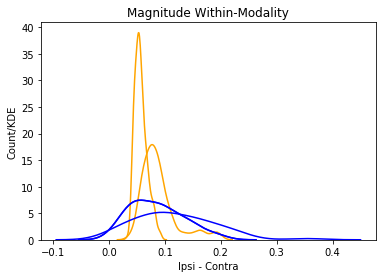

In [188]:
datasets_generate_ips_con_plot(dMRI_datasets, fMRI_datasets, split_pt = desikan_split_pt)


/Users/wilsontang/Desktop/m2g_csvs/BNU1_DMRI
[-0.12319952 -0.08359395 -0.1801928  -0.15110166 -0.09421755 -0.08790708
 -0.09283145 -0.08800944 -0.06635147 -0.07765912 -0.07276542 -0.08282187
 -0.1388381  -0.15929802 -0.08985577 -0.11104664 -0.13395757 -0.1208408
 -0.07603114 -0.0665218  -0.06419438 -0.0851951  -0.08861442 -0.05366716
 -0.08529578 -0.10265605 -0.10551858 -0.09574048 -0.09298759 -0.1048713
 -0.06920366 -0.04444949 -0.07428356 -0.05076237 -0.08876454 -0.14904342
 -0.02407885 -0.01295812 -0.12444848 -0.13441779 -0.07983652 -0.09416951
 -0.06023864 -0.04509565 -0.06138281 -0.08495032 -0.07222424 -0.10418079
 -0.10786165 -0.09804829 -0.06681162 -0.05518438 -0.07583235 -0.08628164
 -0.06859612 -0.04841071 -0.06300069 -0.05147149 -0.2294916  -0.19511249
 -0.04757185 -0.05968462 -0.10962261 -0.04282138 -0.07508958 -0.10048056
 -0.06467796 -0.04200226 -0.07051119 -0.05363469 -0.0647791  -0.08617897
 -0.00634087 -0.00107012 -0.02673269 -0.06759969 -0.07188012 -0.06892116
 -0.0868

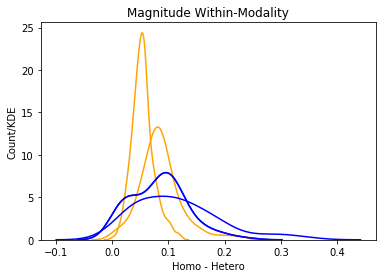

In [189]:
datasets_generate_homo_heter_plot(dMRI_datasets, fMRI_datasets, split_pts = desikan_split_pts)

### CDF Within Modality (applied_SIEM)

In [146]:
i_c_edge_comm = gen_ips_con_edge_comm(desikan_split_pt)
h_h_edge_comm = gen_homo_heter_edge_comm(desikan_split_pts)




[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), 

In [128]:
mag_homo_heter('/Users/wilsontang/Desktop/m2g_csvs/BNU1_DMRI/sub-0025864/ses-1/connectomes/desikan_space-MNI152NLin6_res-2x2x2/sub-0025864_ses-1_dwi_desikan_space-MNI152NLin6_res-2x2x2_connectome.csv',desikan_split_pts)

-1816.7599827511858

In [137]:
a = [1,2]
b = 1
b in a

True

In [148]:
x = [8,4,10,4,9,1,3,3,4,8]
y = [10,5,11,6,11,2,4,5,5,10]

wilcoxon_mann_whitney_test(x, y, alternative="less", method = "asymptotic", alpha = 0.05)
wilcoxon_mann_whitney_test(x, y, alternative="less", method = "exact", alpha = 0.05)

WilcoxonMannWhitneyResult(alternative='less', statistic=123.5, HodgesLehmann=1.5, lowerCI=-2, upperCI=5, pvalue=0.0837915954015025)

In [150]:
from graspy.datasets import load_drosophila_right
adj,labels = load_drosophila_right(return_labels = True)
adj

array([[ 0,  1,  9, ...,  0,  0,  0],
       [12,  0,  7, ...,  0,  0,  0],
       [ 4,  5,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0]])

In [198]:
test_path = '/Users/wilsontang/Desktop/m2g_csvs/BNU1_DMRI/sub-0025864/ses-1/connectomes/desikan_space-MNI152NLin6_res-2x2x2/sub-0025864_ses-1_dwi_desikan_space-MNI152NLin6_res-2x2x2_connectome.csv'
# graph_adj = nx.read_edgelist(test_path, delimiter = ' ')


csvFile = open(test_path, "r")
reader = csv.reader(csvFile)
result =[]
for item in reader:
    result.append(item[0])
csvFile.close()
graph = nx.parse_edgelist(result, nodetype = int, data= (('weight',float),))
# graph = nx.convert_matrix.to_numpy_array(graph)



In [199]:
model = SIEMEstimator()

model.fit(graph,i_c_edge_comm,weighted =True)
print(model.test())



TypeError: 'dict_keys' object does not support indexing

In [ ]:
lines[0].strip().split(" ")
